# Problem 1: Design a Neural Network with Flexible Layer Input

# §0 Defining NN layer initialization, forwardprop, backprop, stochastic gradient descent, etc

I start by importing the data and defining all the relevant methods for training the neural network. To skip this and go to the final training process and results, please skip to [§1](# §1 Constructing NN with [9,3,1] Structure for the Restaurant Domain Prediction).

### Loading Data

In [25]:
import pandas as pd
import numpy as np
import math
import random

# DATA

def load(): 
    """
    10 features with 12 observations
    hard coded from problem statement
    loaded in with features as rows, then transformed with features as columns
    target is last column
    """

    ### LOAD DATA
    Alt = [ "YES", "YES", "NO", "YES", "YES", "NO", "NO", "NO", "NO", "YES", "NO", "YES" ]
    Bar = ["NO", "NO", "YES", "NO", "NO", "YES", "YES", "NO", "YES", "YES", "NO", "YES"]
    Fri = ["NO", "NO", "NO", "YES", "YES", "NO", "NO", "NO", "YES", "YES", "NO", "YES"]
    # Hun = [] # excluded per problem statement
    Pat = ["Some", "Full", "Some", "Full", "Full", "Some", "None", "Some", "Full", "Full", "None", "Full",]
    Price = ["$$$","$","$","$","$$$","$$","$","$$","$","$$$","$","$"]
    Rain = ["NO", "NO", "NO", "YES", "NO", "YES", "YES", "YES", "YES", "NO", "NO", "NO"]
    Res = ["YES", "NO", "NO", "NO", "YES", "YES", "NO", "YES", "NO", "YES", "NO", "NO"]
    Type = ["French", "Thai", "Burger", "Thai", "French", "Italian", "Burger", "Thai", "Burger", "Italian", "Thai", "Burger"]
    Est = ["0-10", "30-60", "0-10" , "10-30", ">60", "0-10", "0-10", "0-10", ">60", "10-30", "0-10", "30-60"]
    # target
    Target = ["Y","N","Y","Y","N","Y","N","Y","N",'N',"N","Y"] #WillWait

    Vars = [Alt, Bar, Fri, Pat, Price, Rain, Res, Type, Est, Target]


    ### ENCODER DICTIONARY
    encoder_dict = {"NO":0, 
                         "YES":1,
                         "N":0, 
                         "Y":1,
                         "None":0, 
                         "Some":1, 
                         "Full":2, 
                         "$":0, 
                         "$$":1, 
                         "$$$":2, 
                         "French":0, 
                         "Thai":1, 
                         "Burger":2, 
                         "Italian":3, 
                         "0-10":0, 
                         "10-30":1, 
                         "30-60":2, 
                         ">60":3}
    

    ### TRANSFORM DATA [ENCODE]
    transformed_vars = []
    for Var in Vars:
        transformed_vars.append([encoder_dict[x] for x in Var])

    X = np.array([x for x in transformed_vars[:-1]]) # don't include target
    #print(X.shape) # features loaded in rows

#     df = pd.DataFrame(X.T) # cols are features
#     print("%s observations consisting of %s features, including target" % (df.shape))
    
    return X.T , np.array([[t] for t in transformed_vars[-1]]) # written this way to get certain shape in labels

X , Y = load()
print("X_train shape:", X.shape, "\nnumber of training examples: %s, number of features: %s" % X.shape)
print("Y_train shape:", Y.shape, "\nnumber of training labels: %s" % Y.shape[0])


k=5
print("first %s inputs:" % k)
print(X[0:k])
print("first %s labels:" % k)
print(Y[0:k])
# if using pandas
# print(X.head())
# print(pd.DataFrame(Y).head())

X_train shape: (12, 9) 
number of training examples: 12, number of features: 9
Y_train shape: (12, 1) 
number of training labels: 12
first 5 inputs:
[[1 0 0 1 2 0 1 0 0]
 [1 0 0 2 0 0 0 1 2]
 [0 1 0 1 0 0 0 2 0]
 [1 0 1 2 0 1 0 1 1]
 [1 0 1 2 2 0 1 0 3]]
first 5 labels:
[[1]
 [0]
 [1]
 [1]
 [0]]


In [26]:
def sigmoid(x):
    
    return 1/(1 + np.exp(-x))

def relu(x): # may not end up using relu for this problem
    
    return max(x,0)

sigmoid(1), relu(1)

(0.7310585786300049, 1)

### Initializing Weights

In [27]:
def initialize(layers):
    """
    initializes all weights and biases in NN to (small) random noise.
    not optimized -– e.g. (He-initialization)
    """
    parameters = {}
    for i in range(len(layers)-1): # for each layer
        parameters["W"+str(i)] = np.random.random(size = (layers[i+1], layers[i]))
        parameters["b"+str(i)] = np.zeros(shape = (layers[i+1],1))


#         for j in range(layers[i]): 
#             cache["W"+str(i)+str(j)] = random.rand()
#             cache["b"+str(i)+str(j)] = random.rand()
        
    return parameters 

# example
layers = [9,3,1]
parameters = initialize(layers)
parameters

{'W0': array([[ 0.09834683,  0.42110763,  0.95788953,  0.53316528,  0.69187711,
          0.31551563,  0.68650093,  0.83462567,  0.01828828],
        [ 0.75014431,  0.98886109,  0.74816565,  0.28044399,  0.78927933,
          0.10322601,  0.44789353,  0.9085955 ,  0.29361415],
        [ 0.28777534,  0.13002857,  0.01936696,  0.67883553,  0.21162812,
          0.26554666,  0.49157316,  0.05336255,  0.57411761]]),
 'W1': array([[ 0.14672857,  0.58930554,  0.69975836]]),
 'b0': array([[ 0.],
        [ 0.],
        [ 0.]]),
 'b1': array([[ 0.]])}

### Forward Pass

In [28]:
def linear_forward(x,W,b):
    """
    input numpy array with shape (current_layer size, 1)
        aka feed in a row of data - so need to transpose it to match W dimensions
    W, b = weights / biases from current layer. shapes:
        (next_layer size ,current_layer size), (next_layer,1) 
        respectively
        
    return linear activation Wx + b
    """
    Z = np.dot(W,x) + b 
    cache = (x, W, b)
    
    assert(Z.shape == (W.shape[0], x.shape[1]))
    return Z , cache

def activation(x,act_fn='sigmoid'):
    """
    applies an activation function to layer output
    default is sigmoid activation
    """
    cache = x
    if act_fn == 'sigmoid':
        return sigmoid(x) , cache
    if act_fn == 'relu':
        return relu(x), cache
    else:
        return "ERROR: no such activation function"


# example

x = np.array(range(layers[0]))
x = np.reshape(a=x, newshape=(x.shape[0],1))
print("input shape", x.shape)

W , b = parameters["W0"], parameters["b0"]
print("linear output shape (Wx and b):", (np.dot(W,x)).shape, b.shape )

x_temp , _ = linear_forward(x,W,b)
print("linear output shape: ", x_temp.shape)

layer_output, _ = activation(x_temp)
layer_output

input shape (9, 1)
linear output shape (Wx and b): (3, 1) (3, 1)
linear output shape:  (3, 1)


array([[ 0.99999999],
       [ 0.99999999],
       [ 0.99999543]])

In [29]:
### Data Test
k=X.shape[0]
print("input")
print(X[0:k].T,"\n")
x = X[0:k].T

W , b = parameters["W0"], parameters["b0"]
x_temp , _ = linear_forward(x,W,b)
print("linear output shape: %r \nshould be (output hidden layer size = %s, number of data rows fed in = %s) \n" % (x_temp.shape,layers[1],k))
A_1, _ = activation(x_temp)
print(A_1,'\n')


W , b = parameters["W1"], parameters["b1"]
A_2_temp , _ = linear_forward(A_1,W,b)
print("linear output shape: %r \nshould be (output hidden layer size = %s, number of data rows fed in = %s) \n" % (A_2_temp.shape,layers[2],k))
A_2, _ = activation(A_2_temp)
print(A_2)

input
[[1 1 0 1 1 0 0 0 0 1 0 1]
 [0 0 1 0 0 1 1 0 1 1 0 1]
 [0 0 0 1 1 0 0 0 1 1 0 1]
 [1 2 1 2 2 1 0 1 2 2 0 2]
 [2 0 0 0 2 1 0 1 0 2 0 0]
 [0 0 0 1 0 1 1 1 1 0 0 0]
 [1 0 0 0 1 1 0 1 0 1 0 0]
 [0 1 2 1 0 3 2 1 2 3 1 2]
 [0 2 0 1 3 0 0 0 3 1 0 2]] 

linear output shape: (3, 12) 
should be (output hidden layer size = 3, number of data rows fed in = 12) 

[[ 0.93713085  0.88451304  0.9323603   0.96411864  0.98590426  0.99424574
   0.91727418  0.95528431  0.98884842  0.99920478  0.69733211  0.98592947]
 [ 0.95508551  0.94304519  0.95633227  0.96658078  0.99308067  0.99520555
   0.94830319  0.92617996  0.99393522  0.9996947   0.71271267  0.99573262]
 [ 0.86777647  0.94516569  0.71414252  0.92809846  0.98663941  0.87409921
   0.62299976  0.84565825  0.97344675  0.969048    0.51333747  0.95477399]] 

linear output shape: (1, 12) 
should be (output hidden layer size = 1, number of data rows fed in = 12) 

[[ 0.78710707  0.79362443  0.76854311  0.79584417  0.80538504  0.79315068
   0.7557244

In [30]:
def layer_forward(x,W,b,act_fn="sigmoid"):
    Z, linear_cache = linear_forward(x,W,b)
    output, activation_cache = activation(Z,act_fn)
    assert (output.shape == (W.shape[0], x.shape[1]))
    return output, (linear_cache, activation_cache)

# example
x = np.array([ [i] for i in range(layers[0])])
W , b = parameters["W"+str(0)], parameters["b"+str(0)]
layer_out , _ = layer_forward(x,W,b)
print('example: single layer forward pass:\n', layer_out)

def forward_pass(X,parameters):
    """
    computes a single forward pass of input: x through the layers
    """
    
    caches = []
    out_ = X
    
    L = len(parameters)//2
    
    for i in range(L):
        W , b = parameters["W"+str(i)], parameters["b"+str(i)]
        out_ , cache = layer_forward(out_,W,b)
        caches.append(cache)
        
    assert(out_.shape == (1,X.shape[1]))
    return out_ , caches

# example
layers = [9,3,1]
parameters = initialize(layers)
# x = np.array([ [i] for i in range(layers[0])])
x = X[0:1].T
out, caches = forward_pass(x,parameters)
print('single complete forward pass', out.squeeze())

example: single layer forward pass:
 [[ 0.99999999]
 [ 0.99999999]
 [ 0.99999543]]
single complete forward pass 0.8770109040651177


In [31]:
# data example
layers = [9,3,1]
parameters = initialize(layers)
out, caches = forward_pass(X.T,parameters)
out

array([[ 0.83703121,  0.83464343,  0.822288  ,  0.84301197,  0.84930895,
         0.84828999,  0.81995278,  0.83901287,  0.85066149,  0.85244978,
         0.73759464,  0.84994975]])

### Loss Function

In [32]:
def loss(y_prediction, y_actual):
    """
    NN loss function - use euclidean error
    """
    
    ### flatten inputs!!!
    pred = y_prediction.flatten()
    labels = y_actual.flatten()
    
    try:
        m = y_actual.shape[0]
    except:
        m = 1

    ### euclidean
#     cost = np.abs(y_actual - y_prediction) # on a single dataset
    diffs = labels - pred
#     print(diffs) # troubleshooting shape
    cost = np.linalg.norm(diffs) / m
    
    ### sigmoid binary cross entropy loss
#     cost = - np.mean( y_actual * np.log(y_prediction) + (1-y_actual) * np.log(1-y_prediction) )
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

# example 
print("predictions (rounded): %s \nlabel: %s" % (np.round(out).astype(int), Y.T))
# print("number of incorrect predictions:", sum([ np.round(out) ]) )
print("loss:", loss(y_prediction=out,y_actual=Y))

predictions (rounded): [[1 1 1 1 1 1 1 1 1 1 1 1]] 
label: [[1 0 1 1 0 1 0 1 0 0 0 1]]
loss: 0.171570621755


### Backwards Pass

In [33]:
def linear_backward(dZ, cache):
    """
    Linear portion of backward propagation for a single layer

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer i)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer i-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W, same shape as W
    db -- Gradient of the cost with respect to b, same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.zeros(shape=np.shape(b)) + (np.sum(dZ, axis=1,keepdims=True) / m) # to broadcast into the right shape
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape), "shapes %r & %r" % (dA_prev.shape, A_prev.shape)
    assert (dW.shape == W.shape), "shapes %r & %r" % (dW.shape, W.shape)
    assert (db.shape == b.shape), "shapes %r & %r" % (db.shape, b.shape)
    
    return dA_prev, dW, db

In [34]:

def sigmoid_backward(dA, activation_cache):
    """
    activation cache = [z] contains the output of the activation function
    """
    Z = activation_cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
#     print("dZ shape:", Z.shape)
    assert (dZ.shape == Z.shape), "shapes are %r and %r" % (dZ.shape, Z.shape)
    
    return dZ
    
def relu_backward(dA, activation_cache):
    return "haven't implemented yet"

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer i
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

#example - backprop from the last layer on single input vector
A_last = out #last activation layer output
label = 1 #corresponding label layer

cache = caches[-1]
linear_cache, activation_cache = cache

# print("linear cache:\n", linear_cache, '\n', "activation cache:\n", activation_cache)
dA_last = - (np.divide(label, A_last) - np.divide(1 - label, 1 - A_last)) # sigmoid cross entropy error
dA_prev, dW, db = linear_activation_backward(dA=dA_last, cache=cache, activation="sigmoid")

dA_prev, dW, db

(array([[-0.15042419, -0.15262818, -0.16403253, -0.1449038 , -0.13909153,
         -0.14003206, -0.166188  , -0.14859507, -0.13784311, -0.13619247,
         -0.24220658, -0.13850007],
        [-0.11595633, -0.1176553 , -0.12644649, -0.11170087, -0.10722041,
         -0.10794543, -0.12810805, -0.11454633, -0.10625805, -0.10498563,
         -0.18670791, -0.10676447],
        [-0.02025229, -0.02054902, -0.02208444, -0.01950905, -0.01872652,
         -0.01885315, -0.02237464, -0.02000603, -0.01855844, -0.01833621,
         -0.03260937, -0.01864689]]),
 array([[-0.15201111, -0.14802709, -0.15645676]]),
 array([[-0.16798376]]))

In [35]:

def backprop(AL, Y, caches):
    """
    Implement the backward propagation for an L layer (LINEAR -> SIGMOID) group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers = 2 –– hidden and output
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # binary cross entropy loss function
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for i in reversed(range(L-1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(i+1)], 
                                                                    current_cache, "sigmoid")
        grads["dA" + str(i)] = dA_prev_temp
        grads["dW" + str(i+1)] = dW_temp
        grads["db" + str(i+1)] = db_temp

    return grads

In [36]:
# example
layers = [9,3,1]
parameters = initialize(layers)

_input = X[0:1].T # np.array([ [i] for i in range(layers[0])])
_out, caches = forward_pass(_input,parameters)

# set label for backprop
label = Y[0] # np.array([1])

grads = backprop(_out,label,caches)

### Updating Weights (Stoch. Grad. Desc.)

In [37]:
print("My 'W' and 'dW' indexing are off by one (0 indexing vs 1 indexing). \nCheck that the corresponding shapes match:\n")
for i in range(len(layers)-1):
    print('W:', grads["dW"+str(i+1)].shape , parameters["W"+str(i)].shape)
    print('b:', grads["db"+str(i+1)].shape , parameters["b"+str(i)].shape)

My 'W' and 'dW' indexing are off by one (0 indexing vs 1 indexing). 
Check that the corresponding shapes match:

W: (3, 9) (3, 9)
b: (3, 1) (3, 1)
W: (1, 3) (1, 3)
b: (1, 1) (1, 1)


In [38]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    
    my numbering convention for params is 0 -> but for grads is 1 -> .. oops?
    """
    L = len(parameters)//2 

    for i in range(L):
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate * grads["dW" + str(i+1)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate * grads["db" + str(i+1)]
    
    return parameters

In [39]:
# example feeding a single input vector x through the network and then backpropogating it
layers = [9,3,1]
parameters = initialize(layers)
print(parameters)
_input = X[0:1].T
_out, caches = forward_pass(_input,parameters)

print("\noutput: %s" % _out[0][0])
# set label for backprop
label = Y[0]
print("loss: %s \n" % loss(_out, label))

grads = backprop(_out,label,caches)

update_parameters(parameters, grads, learning_rate = 0.1)
print(parameters)


{'W0': array([[ 0.07197428,  0.96727633,  0.56810046,  0.20329323,  0.25232574,
         0.74382585,  0.19542948,  0.58135893,  0.97001999],
       [ 0.8468288 ,  0.23984776,  0.49376971,  0.61995572,  0.8289809 ,
         0.15679139,  0.0185762 ,  0.07002214,  0.48634511],
       [ 0.60632946,  0.56885144,  0.31736241,  0.98861615,  0.57974522,
         0.38014117,  0.55094822,  0.74533443,  0.66923289]]), 'b0': array([[ 0.],
       [ 0.],
       [ 0.]]), 'W1': array([[ 0.26491956,  0.06633483,  0.3700842 ]]), 'b1': array([[ 0.]])}

output: 0.648615725171
loss: 0.351384274829 

{'W0': array([[ 0.07382526,  0.96727633,  0.56810046,  0.20514421,  0.2560277 ,
         0.74382585,  0.19728046,  0.58135893,  0.97001999],
       [ 0.84692121,  0.23984776,  0.49376971,  0.62004813,  0.82916572,
         0.15679139,  0.01866861,  0.07002214,  0.48634511],
       [ 0.60677336,  0.56885144,  0.31736241,  0.98906005,  0.58063301,
         0.38014117,  0.55139211,  0.74533443,  0.66923289]]), 'b0

In [40]:
# example feeding the entire input dataset through at once
layers = [9,3,1]
parameters = initialize(layers)
_input = X[0:5].T
_out, caches = forward_pass(_input,parameters)

print("\noutput: %r" % _out)
# set label for backprop
label = Y[0:5]
# print("loss: %s \n" % loss(_out, label))

grads = backprop(_out,label,caches)

update_parameters(parameters, grads, learning_rate = 0.1)




output: array([[ 0.90398036,  0.90657905,  0.87902287,  0.91236586,  0.91514117]])


{'W0': array([[ 0.62896953,  0.21036535,  0.75256884,  0.06506544,  0.26021889,
          0.80478237,  0.19338618,  0.63914369,  0.52259916],
        [ 0.92397015,  0.26373199,  0.06594266,  0.733798  ,  0.77211355,
          0.90785721,  0.93193983,  0.01401643,  0.23253022],
        [ 0.61632378,  0.94917513,  0.95017483,  0.55584743,  0.91567648,
          0.64158527,  0.39004278,  0.48581865,  0.60325107]]),
 'W1': array([[ 0.52019287,  0.89615595,  0.88871485]]),
 'b0': array([[-0.00055664],
        [-0.0004026 ],
        [-0.00029577]]),
 'b1': array([[-0.03034179]])}

### Performance Heuristic Functions

methods for uzing the NN, getting accuracy, measuring convergence of the weights and gradients, etc.

In [41]:
# for computing convergence of weights
def weight_sum(parameters, distinguish=True, param_names = ["W","b"]):
    """
    computes sum of Froeb norm of weights associated with the neural net
    if distinguish: treats weights W and biases b separately
    """
    W = param_names[0]
    b = param_names[1]
    
    if distinguish:
        weights = [ parameters[key] for key in parameters.keys() if key[0:len(W)] == W ]
        biases = [ parameters[key] for key in parameters.keys() if key[0:len(b)] == b ]
        
        return np.mean([ np.linalg.norm(x) for x in weights ]) , np.mean([ np.linalg.norm(x) for x in biases ])
    else:
        return np.mean([ np.linalg.norm( parameters[key]) for key in parameters.keys() ])
    
print("mean weights norm: %r, %r" % weight_sum(parameters))
print("mean gradient norm: %r, %r" % weight_sum(grads, param_names = ["dW", "db"]))


mean weights norm: 2.321822187369782, 0.015544862877474083
mean gradient norm: 0.2775188855768676, 0.15544862877474083


In [42]:
# prediction function to make life easier

def predict(X,parameters):
    """
    computes a single forward pass (no backprop) of the NN model on the input X
    transposes input automatically
    """
    prediction, _ = forward_pass(X.T,parameters)
    return prediction

def accuracy(X,Y,parameters):
    """
    computes accuracy (categorical)
    """
    prediction = predict(X.T,parameters)
    difference = np.abs(Y - prediction.T)
    return len([x for x in difference if x < 0.2])/len(Y)

In [43]:
# accuracy example
predicts = np.array([1,0,0,1,1,0])
actuals = np.array([1,0,1,0,0,0])
print("Predictions:", predicts, "\nLabels:", actuals)
# compute accuracy from scratch
differences = np.abs(actuals - predicts)
# print(differences)
successes = [x for x in differences if x < 0.2]
# print(successes)
len([x for x in differences if x < 0.2])/len(actuals)


Predictions: [1 0 0 1 1 0] 
Labels: [1 0 1 0 0 0]


0.5

### Complete NN Training Procedure

In [44]:
def train_nn(X, Y, layers, epochs=10, learning_rate=0.05, update_rate = .1):
    """
    trains a simple fully connected neural net with sigmoid activation
    X = input shape should be (num obs, num features).T (?)
    Y = labels shape should be (num obs, 1)
    epochs = number of full forward + backward propogations to carry out
    learning rate = learning rate for SGD parameter updates
    update_rate = how often to get update messages (on epoch, cost, weights, accuracy)
        default = 10% of the time during a run
    """
    parameters = initialize(layers)
    costs = []
    acc = []
    
    initial_weight_score = weight_sum(parameters)
    weight_scores = [initial_weight_score] # for plotting convergence of weights
    grad_scores = []

    for i in range(epochs):
        prediction, caches = forward_pass(X,parameters)
        costs.append(loss(prediction, Y))
        
        grads = backprop(prediction,Y,caches)
        update_parameters(parameters, grads, learning_rate=learning_rate)
        weight_scores.append(weight_sum(parameters))
        grad_scores.append(weight_sum(grads,param_names=["dW", "db"]))
        
        accuracy_i = accuracy(X,Y,parameters)
        acc.append(accuracy_i)
        
        if i % int(epochs*update_rate) == 0:
            print("epoch %s of %s, cost: %s, weights: %r" % (' '*(len(str(epochs)) - len(str(i)))+str(i), epochs, loss(prediction, Y), weight_sum(parameters)))
            print("accuracy at epoch %s: %s \n" % (str(i)+'/'+str(epochs), accuracy_i))
            
    return parameters, costs, weight_scores, grad_scores, acc


# §1 Constructing NN with [9,3,1] Structure for the Restaurant Domain Prediction

In [45]:
# train network
np.random.seed(0)

layers = [9,3,1]
parameters, costs, weight_scores, grad_scores, train_accuracy = train_nn(X=X.T, Y=Y, 
                                                                         layers=layers, 
                                                                         epochs=1000, 
                                                                         learning_rate=2)
# costs , weight_scores
print('\nfinal accuracy: %s' % accuracy(X.T,Y,parameters))

epoch    0 of 1000, cost: 0.175277451795, weights: (1.8472241912504521, 0.37300811994675009)
accuracy at epoch 0/1000: 0.0 

epoch  100 of 1000, cost: 0.134455772475, weights: (3.3214566207264804, 1.3977030968766091)
accuracy at epoch 100/1000: 0.0 

epoch  200 of 1000, cost: 0.0931641077641, weights: (6.1014127355025423, 2.2277681120538242)
accuracy at epoch 200/1000: 0.5 

epoch  300 of 1000, cost: 0.0756494587698, weights: (8.1594138846631239, 2.4801309761297112)
accuracy at epoch 300/1000: 0.5833333333333334 

epoch  400 of 1000, cost: 0.0749322950712, weights: (8.9768090657141695, 2.5197227290660664)
accuracy at epoch 400/1000: 0.75 

epoch  500 of 1000, cost: 0.0253007551314, weights: (10.438414564452323, 3.4831882085150987)
accuracy at epoch 500/1000: 1.0 

epoch  600 of 1000, cost: 0.00683626296418, weights: (11.630631150844865, 3.9582114398389634)
accuracy at epoch 600/1000: 1.0 

epoch  700 of 1000, cost: 0.00455824770221, weights: (12.339125266831683, 4.1054633133330389)
acc

In [46]:
print("accuracy: %s, \ni.e. %s of %s observations correctly predicted." % (accuracy(X.T,Y,parameters), len(Y) * accuracy(X.T,Y,parameters), len(Y)))


accuracy: 1.0, 
i.e. 12.0 of 12 observations correctly predicted.


### Visualizing the NN Training

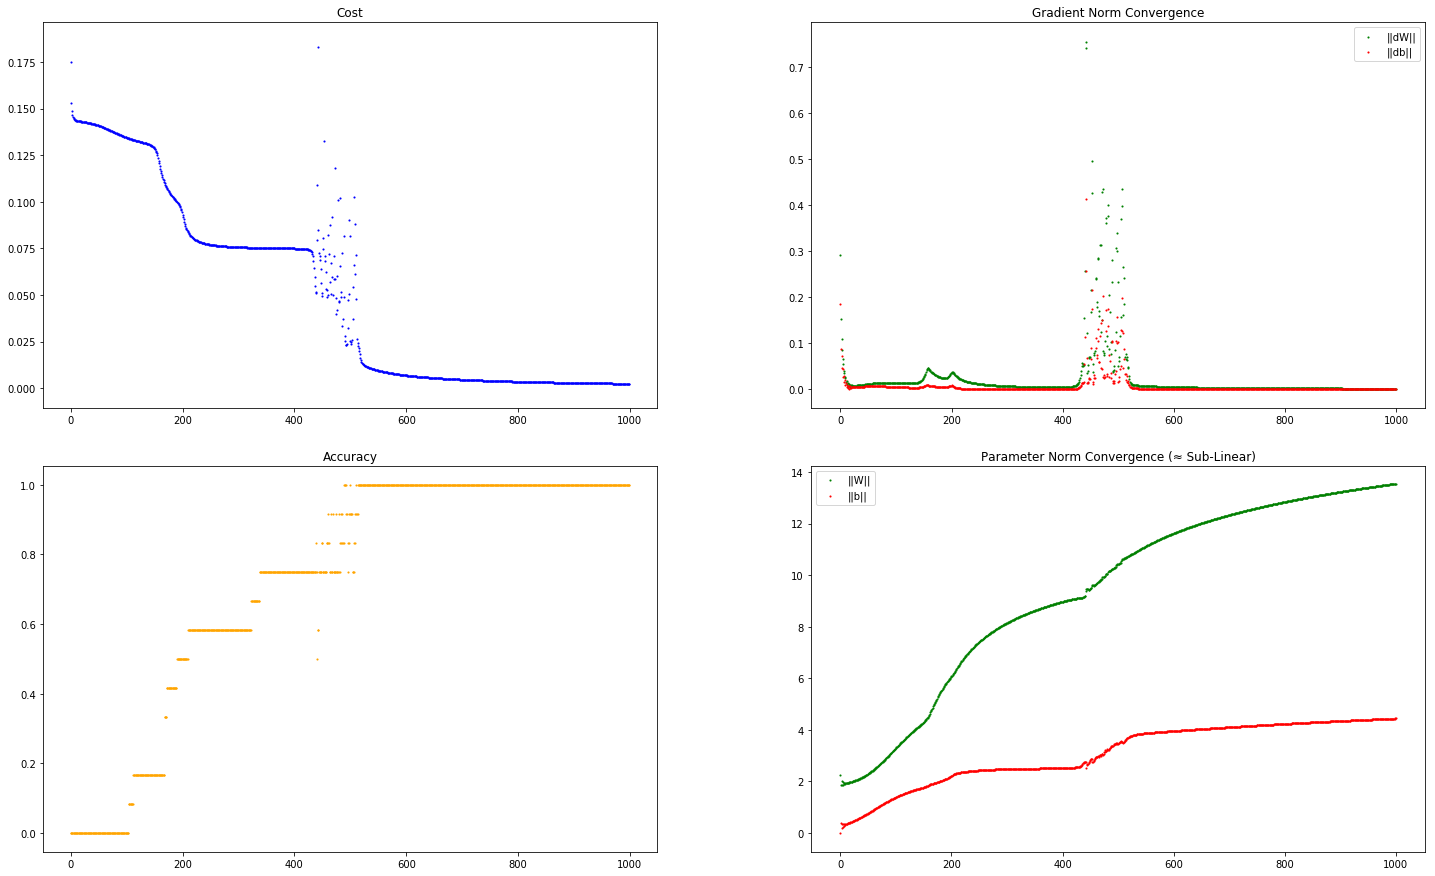

In [47]:
# visualize
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots - default is [6.0, 4.0]


def visualize(parameters, costs, weight_scores, grad_scores, train_accuracy):
    """
    2x2 matrix of NN diagnostics –– cost, accuracy, and weights, gradients
    
                _________________________________________    
               |                    |                    |
               |                    |                    |
               |      COST          |          WEIGHTS   |
               |                    |                    |
               |____________________|____________________|
               |                    |                    |
               |                    |                    |
               |      ACCURACY      |          GRADS     |
               |                    |                    |
               |____________________|____________________|
                                    
    
    """
    
#     num_rows = 2
#     num_cols = 2
    
    size = 1.2
    
    plt.subplot(221)
    # plt.scatter(x=range(len(costs)),y=[1-x for x in costs],s=1,c='blue')
    plt.scatter(x=range(len(costs)),y=costs,s=size,c='blue')
    plt.title("Cost")
#     plt.show()

    plt.subplot(223)
    plt.scatter(x=range(len(train_accuracy)),y=train_accuracy,s=size,c='orange')
    plt.title("Accuracy")
#     plt.show()
    
    plt.subplot(224)
    weights, biases = np.array(weight_scores).T
    weight_plot = plt.scatter(x=range(len(weights)),y=weights,s=size,c='green',label = '||W||')
    bias_plot = plt.scatter(x=range(len(biases)),y=biases,s=size,c='red',label='||b||')
    plt.title("Parameter Norm Convergence (≈ Sub-Linear)")
    plt.legend()
#     plt.show()

    plt.subplot(222)
    weights, biases = np.array(grad_scores).T
    weight_plot = plt.scatter(x=range(len(weights)),y=weights,s=size,c='green',label = '||dW||')
    bias_plot = plt.scatter(x=range(len(biases)),y=biases,s=size,c='red',label='||db||')
    plt.title("Gradient Norm Convergence")
    plt.legend()
#     plt.show()

    plt.subplots_adjust(top=2.5, bottom=0.58, 
                        left=.10, right=2.5, 
                        hspace=0.15, wspace=0.25)
    
    plt.show()



visualize(parameters, costs, weight_scores, grad_scores, train_accuracy)

### Report Weights

Weights $\mathbf{W}$ and biases $\mathbf{b}$ associated with the trained NN model:

In [53]:
parameters

{'W0': array([[ 0.72735356,  0.61697924,  0.74672344,  2.72420446,  1.4800029 ,
         -0.61418652,  1.27680695, -0.44681846,  0.695036  ],
        [ 0.52037497,  1.22383435,  0.68570749,  5.2059696 ,  2.43301263,
         -1.83707426,  1.5246772 , -0.75560607,  0.64597477],
        [-1.60888083, -4.53493929, -2.3723166 , -3.13990341,  3.59921858,
         -2.44006964, -0.7289598 ,  2.90893943,  5.55738472]]),
 'W1': array([[  2.6064807 ,   7.93198795, -12.13348709]]),
 'b0': array([[-1.27960437],
        [-1.79656621],
        [-3.93031782]]),
 'b1': array([[-4.38154803]])}

We can see the network seems to be growing well, but hasn't yet achieved 100% accuracy. We can try training for more epochs, or adjusting the learning rate. Below I run the same network for a longer time, achieving a desired high accuracy: 

Another point: we could change the random initialization of weights - even setting the random seed some other values can lead to an accuracy of 1.0 within the same training regime with epochs ≤ 1000 [e.g., seed(10)].

**N.B. Adjusting bias initialization has rendered this moot, as we can now easily achieve 100% accuracy within 600 epochs.**

epoch    0 of 7000, cost: 0.158417626247, weights: (1.6850350829501373, 0.24910657703641598)
accuracy at epoch 0/7000: 0.0 

epoch 3500 of 7000, cost: 0.000414184992098, weights: (16.144955681959427, 2.8310792576409263)
accuracy at epoch 3500/7000: 1.0 


Final Accuracy: 1.0


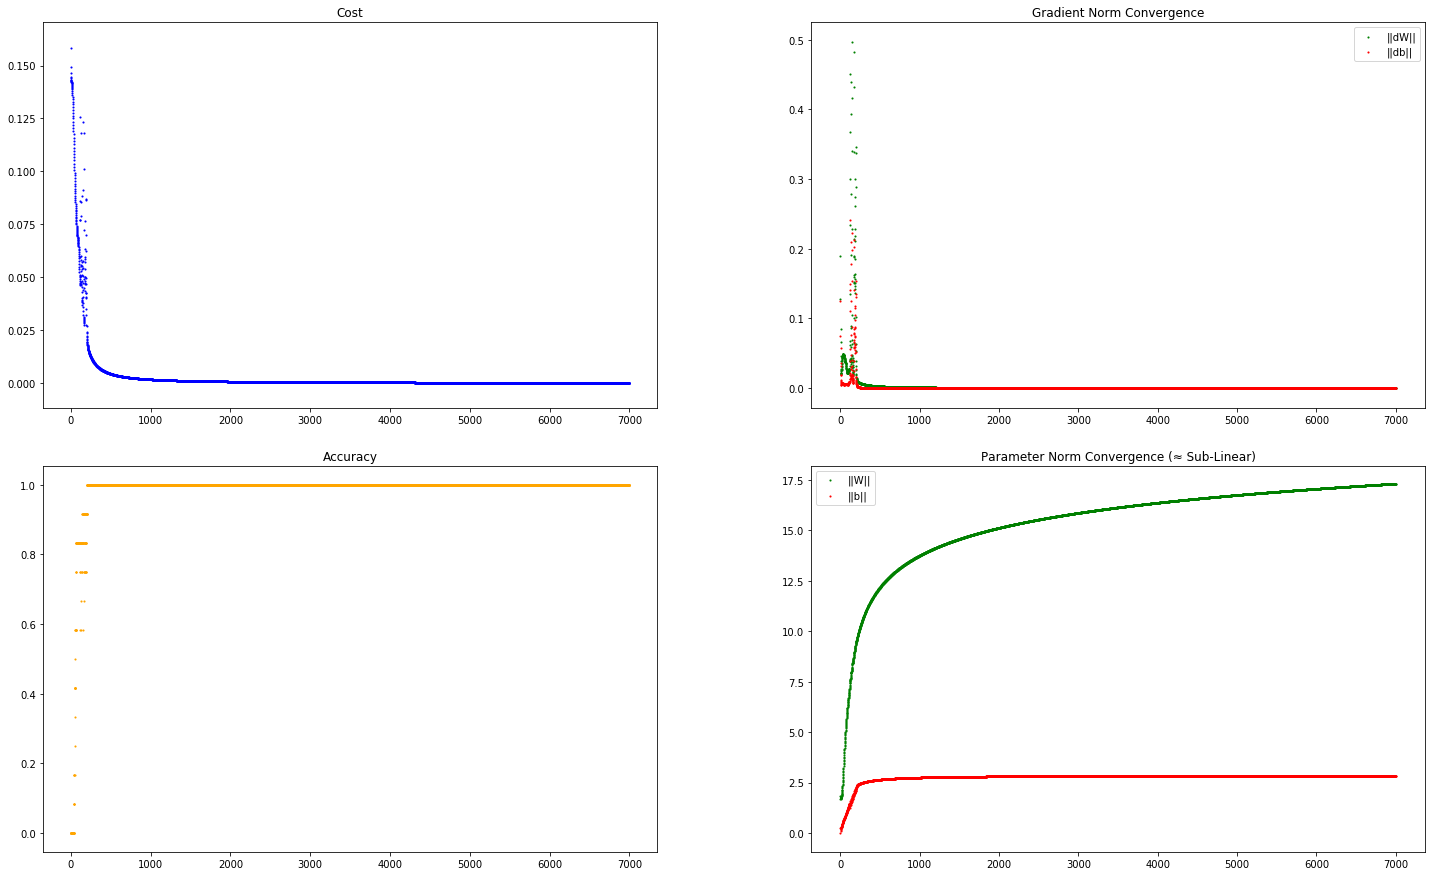

In [24]:
np.random.seed(1)

layers = [9,3,1]
parameters, costs, weight_scores, grad_scores, train_accuracy = train_nn(X=X.T, Y=Y, 
                                                                         layers=layers, 
                                                                         epochs=7000, 
                                                                         learning_rate=2,
                                                                         update_rate=.5)
print('\nFinal Accuracy: %s' % train_accuracy[-1])
visualize(parameters, costs, weight_scores, grad_scores, train_accuracy)

# §2 Toy Dataset

I generate toy dataset (continuous) and labels to test the network on. This is still incomplete.

In [592]:
# test dataset
num_observations , num_features = train_shape =  (1000, 20)
X_train = np.random.normal(size=train_shape,loc=range(20),scale=1)

# create labels
Y_train = np.array([i for i in range(num_observations)]).T
# print(X_train[0] , "\n", Y_train[0])

for i in range(num_observations):
    x = X_train[i]
    temp = sum( [(x[j] - j) > 0 for j in range(num_features)] )
    if temp > num_features/2: 
        Y_train[i] = 1
    else:
        Y_train[i] = 0
        
Y_train = np.reshape(a=Y_train, newshape=(Y_train.shape[0],1))

print("X_train shape:", X_train.shape, "\nnumber of training examples: %s, number of features: %s\n" % X_train.shape)
print("Y_train shape:", Y_train.shape, "\nnumber of training labels: %s\n" % Y_train.shape[0])


print("first 25 labels:", Y_train[0:25].T)

print("proportion of '0' labels: %s" % (1-sum(Y_train)/len(Y_train)))
print("proportion of '1' labels: %s" % (sum(Y_train)/len(Y_train)))

X_train shape: (1000, 20) 
number of training examples: 1000, number of features: 20

Y_train shape: (1000, 1) 
number of training labels: 1000

first 25 labels: [[0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1]]
proportion of '0' labels: [ 0.577]
proportion of '1' labels: [ 0.423]


In [628]:
# train network
np.random.seed(0)

layers = [num_features,5,1]
parameters, costs, weight_scores, grad_scores, train_accuracy = train_nn(X=X_train.T, Y=Y_train, 
                                                                         layers=layers, 
                                                                         epochs=1000, 
                                                                         learning_rate=1.5, 
                                                                         update_rate=.2)

epoch    0 of 1000, cost: 0.0232273108493, weights: (3.1347815982239826, 0.90182130534538418)
accuracy at epoch 0/1000: 0.577 

epoch  200 of 1000, cost: 0.0172833328824, weights: (3.1252002883393506, 0.8956943931997785)
accuracy at epoch 200/1000: 0.577 

epoch  400 of 1000, cost: 0.0172833328824, weights: (3.1252002883393994, 0.8956943931996203)
accuracy at epoch 400/1000: 0.577 

epoch  600 of 1000, cost: 0.0172833328824, weights: (3.1252002883394479, 0.89569439319946209)
accuracy at epoch 600/1000: 0.577 

epoch  800 of 1000, cost: 0.0172833328824, weights: (3.1252002883394967, 0.895694393199304)
accuracy at epoch 800/1000: 0.577 



In [629]:
# print('\nfinal accuracy: %s' % accuracy(X_train.T,Y_train,parameters))

In [630]:
# visualize(parameters, costs, weight_scores, grad_scores, train_accuracy)